In [2]:
!pip install konlpy
!pip install wordcloud

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 448 kB 51.3 MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (8,292 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: una

In [3]:
import re
from datetime import datetime
import collections

import requests, json
from bs4 import BeautifulSoup
import urllib.parse as parse

from tqdm import tqdm
import pickle

import numpy as np
import pandas as pd
import sklearn as sk

from konlpy.tag import Okt # komoran, hannanum, kkma, mecab
import gensim
from gensim.summarization import summarize

#visualization
import matplotlib as mpl
import matplotlib.pylab as plb
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rcParams
import seaborn as sns
from wordcloud import WordCloud

# 브라우저에서 바로 그려지도록 
# %matplotlib inline

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# # Colab 의 한글 폰트 설정
# plt.rc('font', family='NanumSquareRound') 

# 유니코드에서  음수 부호설정
mpl.rc('axes', unicode_minus=False)

# Seaborn 테마 설정
sns.set_theme(style="ticks", color_codes=True, font='NanumSquareRound', font_scale=2)

# 워닝 메세지 삭제
import warnings
warnings.filterwarnings(action='ignore')

# font_list = [font.name for font in fm.fontManager.ttflist]
# font_list

In [2]:
font_list = [font.name for font in fm.fontManager.ttflist]
font_list
path = '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf'

In [3]:
# 피클 사용법
# list = ['a', 'b', 'c']
# with open('list.txt', 'wb') as f:
#   pickle.dump(list, f)

# with open('list.txt', 'rb') as f:
#   data = pickle.load(f)

In [4]:
df = pd.read_csv('러시아 한국 경제_v2_2022041520220224.csv')

In [5]:
def clean_content(content):
  stripped = content[69:-2]
  cleaned = re.sub('[^가-힣ㄱ-ㅣa-zA-Z|0-9.%]', ' ', string=stripped)
  return cleaned

def clean_title(title):
  cleaned = re.sub('[^가-힣ㄱ-ㅣa-zA-Z|0-9.%]', ' ', string=title)
  return cleaned

In [6]:
df['내용'] = df['내용'].apply(clean_content)

In [7]:
df['제목'] = df['제목'].apply(clean_title) + '.'

In [8]:
df['제목내용'] = df['제목'] + ' ' + df['내용']

In [9]:
df['제목내용'][0]

' 오늘 점심 칼국수 어때   이런말 못하겠네 서울서 8000원 첫 돌파. 우크라 사태로 밀 가격 고공행진밀 선물가격 1년 전  75.8% 칼국수  매경DB  서울에서 대표적 서민음식인 칼국수 평균 가격이 8000원 선을 처음으로 넘어섰다.  러시아의 우크라이나 침공 사태와 해상운임 상승 등이 겹치면서 밀 가격이 급등한 탓이다.14일 한국농촌경제연구원의 해외곡물시장정보에 따르면 지난 12일 기준 시카고선물거래소의 밀 선물 가격은 t당 405.55달러로 1년 전 230.75달러  대비 75.8% 급등했다. 지난달 7일에는 475.46달러까지 치솟아 1년 전 대비 거의 두 배를 기록했다.러시아와 우크라이나는 세계 밀 수출량의 약 29%를 차지하고 있다. 러시아는 세계 최대 밀 수출국이며  우크라이나는  유럽의 빵 바구니 로도 불린다.밀 가격 급등으로 밀가루를 사용하는 외식 물가의 부담도 커지고 있다. 한국소비자원 가격정보 종합포털  참가격 을 보면 지난달 서울 지역의 칼국수 평균 가격은 1년 전보다 8.7% 올라 8113원이다. 서울 지역 칼국수 가격이 8000원을 넘은 것은 이번이 처음이다. 지난달에는 7962원으로 8000원에 육박했다. 자료   한국소비자원 참가격  밀가루를 사용하는 냉면이나 자장면도 다른 외식 품목보다 많이 올랐다. 지난달 서울 지역 냉면 가격은 9962원으로 지난해 같은 달보다 9.7% 올랐고  자장면은 5846원으로 9.4% 상승했다. 같은 기간 비빔밥 7.0% 은 물론  김치찌개백반 5.7%   김밥 5.2%   삼겹살 3.5% . 삼계탕 0.3%  등 안오른 품목이 없지만  칼국수나 냉면에 비해서는 상대적으로 낮은 상승률을 보였다.서울 지역 냉면 가격은 곧 1만원 선을 넘을 것으로 보인다. 이미 유명 평양냉면집들의 냉면 한 그릇은 1만1000 1만5000원에 판매되고 있다.한국농촌경제연구원은  우크라이나 사태에 따른 곡물 국제가격 상승으로 단기적 대체 원산지 개발과 국내 물가 영향 최소화를 위한 금융 및 세제 지원을 강화해야 한다 면

In [10]:
# for idx in range(len(df['제목내용'])):
#   try:
#     df['제목내용'].iloc[idx] = summarize(df['제목내용'].iloc[idx], ratio=0.5)
#   except Exception as e:
#     print(idx)
#     print(e)

In [11]:
df['제목내용'][0]

' 오늘 점심 칼국수 어때   이런말 못하겠네 서울서 8000원 첫 돌파. 우크라 사태로 밀 가격 고공행진밀 선물가격 1년 전  75.8% 칼국수  매경DB  서울에서 대표적 서민음식인 칼국수 평균 가격이 8000원 선을 처음으로 넘어섰다.  러시아의 우크라이나 침공 사태와 해상운임 상승 등이 겹치면서 밀 가격이 급등한 탓이다.14일 한국농촌경제연구원의 해외곡물시장정보에 따르면 지난 12일 기준 시카고선물거래소의 밀 선물 가격은 t당 405.55달러로 1년 전 230.75달러  대비 75.8% 급등했다. 지난달 7일에는 475.46달러까지 치솟아 1년 전 대비 거의 두 배를 기록했다.러시아와 우크라이나는 세계 밀 수출량의 약 29%를 차지하고 있다. 러시아는 세계 최대 밀 수출국이며  우크라이나는  유럽의 빵 바구니 로도 불린다.밀 가격 급등으로 밀가루를 사용하는 외식 물가의 부담도 커지고 있다. 한국소비자원 가격정보 종합포털  참가격 을 보면 지난달 서울 지역의 칼국수 평균 가격은 1년 전보다 8.7% 올라 8113원이다. 서울 지역 칼국수 가격이 8000원을 넘은 것은 이번이 처음이다. 지난달에는 7962원으로 8000원에 육박했다. 자료   한국소비자원 참가격  밀가루를 사용하는 냉면이나 자장면도 다른 외식 품목보다 많이 올랐다. 지난달 서울 지역 냉면 가격은 9962원으로 지난해 같은 달보다 9.7% 올랐고  자장면은 5846원으로 9.4% 상승했다. 같은 기간 비빔밥 7.0% 은 물론  김치찌개백반 5.7%   김밥 5.2%   삼겹살 3.5% . 삼계탕 0.3%  등 안오른 품목이 없지만  칼국수나 냉면에 비해서는 상대적으로 낮은 상승률을 보였다.서울 지역 냉면 가격은 곧 1만원 선을 넘을 것으로 보인다. 이미 유명 평양냉면집들의 냉면 한 그릇은 1만1000 1만5000원에 판매되고 있다.한국농촌경제연구원은  우크라이나 사태에 따른 곡물 국제가격 상승으로 단기적 대체 원산지 개발과 국내 물가 영향 최소화를 위한 금융 및 세제 지원을 강화해야 한다 면

In [12]:
okt = Okt()

doc_tokenized = df['제목내용'].apply(okt.morphs, stem= True)

# print('OKT 형태소 분석 :',okt.morphs("열심히 코딩한 당신, 연휴에는 여행을 가봐요"))
# print('OKT 품사 태깅 :',okt.pos("열심히 코딩한 당신, 연휴에는 여행을 가봐요"))
# print('OKT 명사 추출 :',okt.nouns("열심히 코딩한 당신, 연휴에는 여행을 가봐요")) 

In [5]:
okt = Okt()
okt.nouns('데니소바는 오늘 우리나라에 방문했다.')

['데니', '소바', '오늘', '우리나라', '방문']

In [13]:
def oneWordRemoval(lst):
  for el in lst:
    if len(el) <= 1:
      lst.remove(el)

doc_tokenized.apply(oneWordRemoval)

0       None
1       None
2       None
3       None
4       None
        ... 
1451    None
1452    None
1453    None
1454    None
1455    None
Name: 제목내용, Length: 1456, dtype: object

In [14]:
dictionary = gensim.corpora.Dictionary(doc_tokenized)
# print(dictionary.token2id)
# print('dictionary size : %d' % len(dictionary))

In [15]:
BoW_corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in doc_tokenized]

In [16]:
# for doc in BoW_corpus:
#   #  print([[dictionary[id], freq] for id, freq in doc])
#    print([[id, freq] for id, freq in doc])

In [17]:
tfidf = gensim.models.TfidfModel(BoW_corpus, smartirs='ntc')

In [18]:
# for doc in tfidf[BoW_corpus]:
#   print([[dictionary[id], np.around(freq, decimals=2)] for id, freq in doc])

In [19]:
with open('tfidf.txt', 'wb') as f:
  pickle.dump(tfidf, f)

In [20]:
num = 0
for doc in tfidf[BoW_corpus]:
  for id, freq in doc:
    num += 1
print(num)

446405


In [21]:
tfidf_dic = {dictionary.get(id): freq for doc in tfidf[BoW_corpus] for id, freq in doc}

In [22]:
toDataFrame = {
  '단어': tfidf_dic.keys(),
  '빈도': tfidf_dic.values(),    
}

pd.DataFrame(toDataFrame)

,단어,빈도
0,0.3%,0.050378
1,1000,0.022274
2,12일,0.047645
3,14일,0.072529
4,1년,0.013892
...,...,...
26904,99.5달러,0.085196
26905,View,0.085196
26906,곽병열,0.085196
26907,넷,0.085196


In [23]:
len(tfidf_dic)

26909

In [24]:
# with open('tfidf_dic.txt', 'rb') as f:
#   tfidf_dic = pickle.load(f)

In [25]:
font_path = '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf'

In [26]:
w = WordCloud(width=1500, height=1200, mode='RGBA', background_color='white', max_words=1000, font_path = font_path).fit_words(tfidf_dic)

In [27]:
tfidf_dic['누에'], tfidf_dic['도넛']

(0.7839883157155182, 0.7421460081708776)

In [28]:
plt.figure(figsize=(20,15))
plt.imshow(w)
plt.axis('off')
plt.savefig('러시아 한국 경제 워드클라우드_1000.png')

Output hidden; open in https://colab.research.google.com to view.

In [29]:
w_500 = WordCloud(width=1500, height=1200, mode='RGBA', background_color='white', max_words=500, font_path = font_path).fit_words(tfidf_dic)

In [30]:
plt.figure(figsize=(20,15))
plt.imshow(w_500)
plt.axis('off')
plt.savefig('러시아 한국 경제 워드클라우드_500.png')

Output hidden; open in https://colab.research.google.com to view.

In [31]:
w_100 = WordCloud(width=1500, height=1200, mode='RGBA', background_color='white', max_words=100, font_path = font_path).fit_words(tfidf_dic)

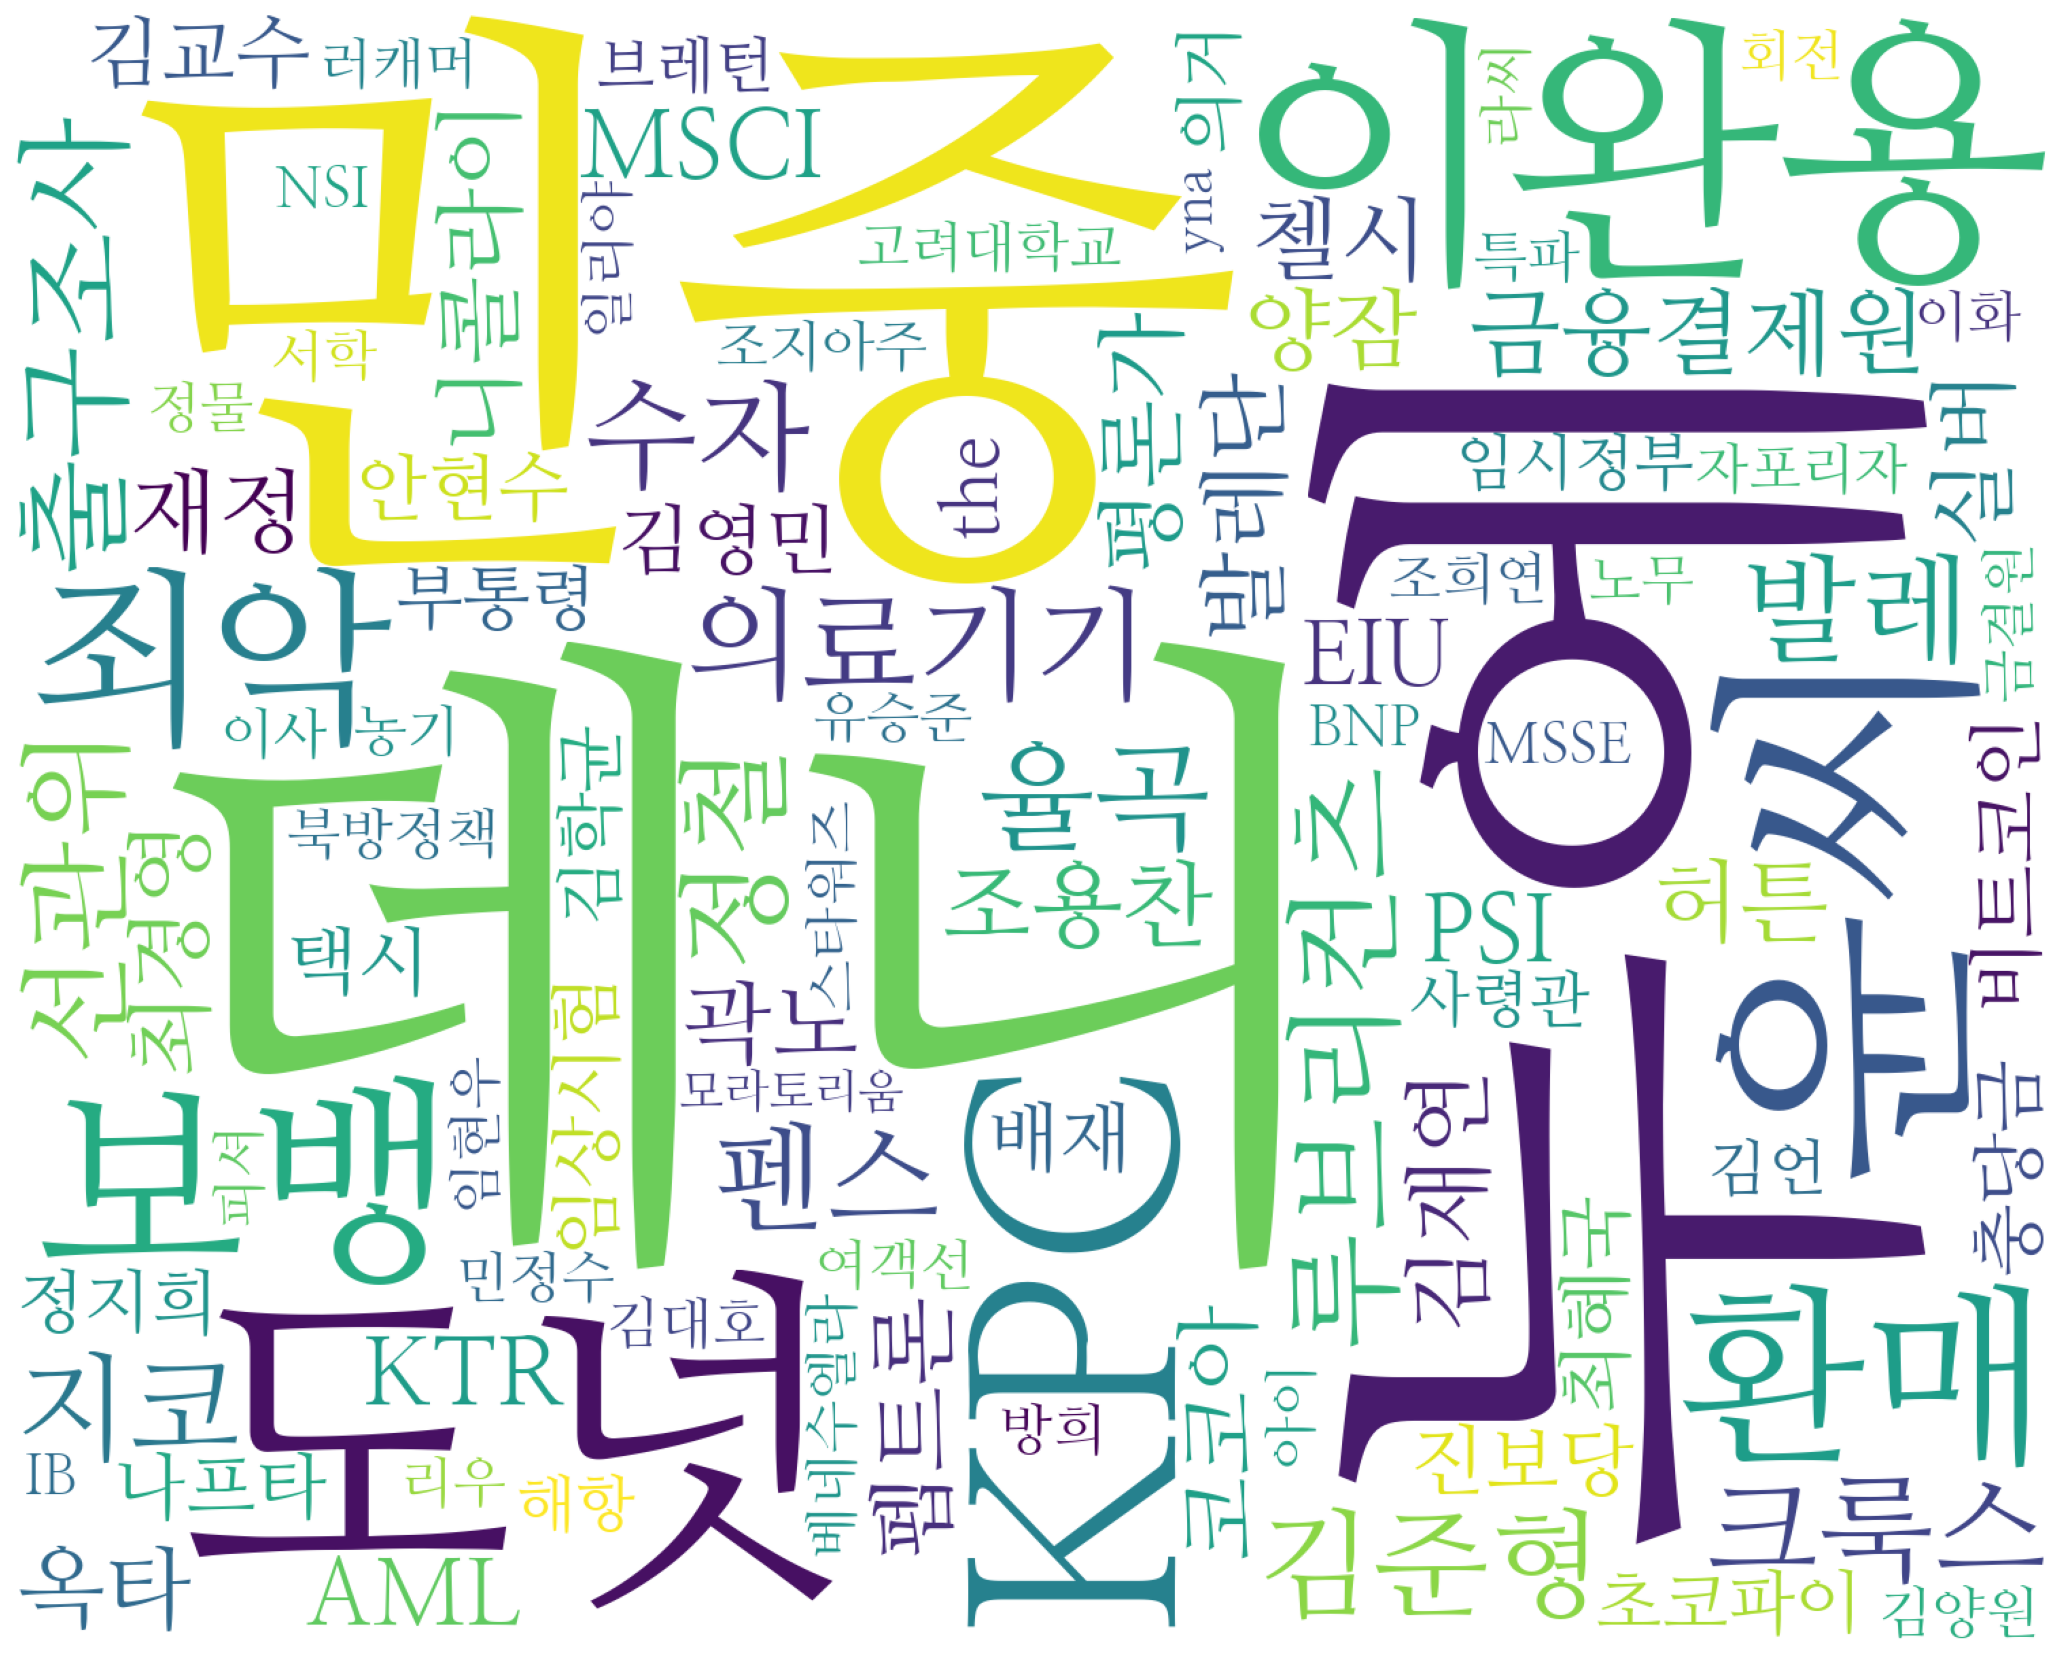

In [32]:
plt.figure(figsize=(20,15))
plt.imshow(w_100)
plt.axis('off')
plt.savefig('러시아 한국 경제 워드클라우드_100.png')

In [33]:
od = {v: k for k, v in tfidf_dic.items()}

In [34]:
ordered_keys = sorted(od.keys())

In [35]:
tfidf_od = {od[k]: k for k in ordered_keys}

In [36]:
keys = list(tfidf_od.keys())
keys.reverse()
for i in range(50):
  key = keys[i]
  print(key, tfidf_od[key])

데니 0.8038555659565002
누에 0.7839883157155182
민중 0.77337683522515
도넛 0.7421460081708776
이완용 0.7264087411848139
윤씨 0.719182103676388
KPC 0.7124451550913774
보뱅 0.7044648862624195
환매 0.6794975050430493
죄악 0.6740288651818601
의료기기 0.6551342789711417
루브리컨츠 0.6368493162066848
김준형 0.6267671125905758
펜스 0.6210382338527369
율곡 0.6183108427492969
출구조사 0.6109718468937508
발레 0.6093024432980392
크룩스 0.6063673285596097
정철 0.6038219899857613
지코 0.5903265107113232
수자 0.5878215151753725
선관위 0.5753648602292524
금융결제원 0.5744860181684047
PSI 0.5726735758898654
조용찬 0.5713296914205501
KTR 0.5712911438242161
MSCI 0.5689853969542609
발레단 0.5563196221416881
김재연 0.5439112434886559
펩트론 0.5394603145339408
첼시 0.5390918232463651
평론가 0.5361504278015693
허튼 0.5332099822437015
니콜라이 0.5273918269495527
재정 0.5253527902176378
곽노 0.5230532128958729
AML 0.5190350122031503
실버 0.5187759749227866
최경영 0.5104073573963495
옥타 0.506517948545849
양잠 0.5057989133648505
코코아 0.4923239958601606
EIU 0.48889174050497025
김교수 0.48789538941091587
진보당